# Structured Sparsity

## Description

In a target application, we want to sense the components of a signal $\mathbf{x}$, that we indicate as $x_i$, with $ i = 0,\dots, N -1 $. We know that $\mathbf{x}$ is a sparse signal, such that if the  $x_i \, \text{with} \, i < \lfloor \frac{N}{2}\rfloor $ is non-zero, then $x_{i + \lfloor \frac{N}{2}\rfloor }$ is also non-zero. This is to say that the support of the first half and second half of  $\mathbf{x}$ follows the same structure. The goal of this project is to develop and evaluate techniques to recover such sparse signals.

We use $\mathbf{x}$ to denote an Nx1 real-valued sparse vector. The vector of $M$ measurements in our setup is given by $\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{v}$ where $\mathbf{A}$ is an $M \times N$ random CS matrix and $\mathbf{v}$ is a a Nx1 vector of white Gaussian noise samples. The entries of $\mathbf{A}$ are drawn from the standard Gaussian Distribution $\mathcal{N}(0,1)$, and then the colums are normalized to have unit $\ell2$ norm. The vector $\mathbf{v}$ is additive white Gaussian noise. In this project, we use $N = 64$. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import time

# xdata = np.load('data/Project_Structured_Sparsity.npy')
# xdata.shape

## Methodology and Evaluation

Conduct a brief literature study to orient yourself on this problem. Implement convex optimization-based algorithms to recover the structured sparse signal. Compare your developed method with a general CS-recovery algorithm (such as ISTA) that does not exploit the structured sparsity.

The methods must be evaluated on the “Project_Structured_Sparsity.npy” dataset using performance metrics such as reconstruction error and computational time. These metrics must be studied as a function of the number of measurements, i.e., $M$. 

Generating sparse vectors with the given structure:

In [2]:
from utils.generate_structured_data import *

M = 8               # Number of Measurements
N = 64              # Number of original variables
NS = 5000           # Number of samples
K = 4               # Number of non-zero entries within the first half of the vector
noise_var = 0.1     # Noise variance

Y, A, X = generate_structured_data(num_measurements=M, num_variables=N, num_samples=NS, sparsity_half=K, noise_var=noise_var)

In [3]:
print(f"Dimensions:\nY = {Y.shape}\nA = {A.shape}\nX = {X.shape}")

Dimensions:
Y = (8, 5000)
A = (8, 64)
X = (64, 5000)


Saving results:

In [4]:
from scipy.io import savemat
out_mat = dict()
out_mat['X'] = X

np.save("data/Project_Structured_Sparsity", X)
savemat("data/Project_Structured_Sparsity.mat", out_mat)

Visualizing our data:

SNR = 5.88 dB


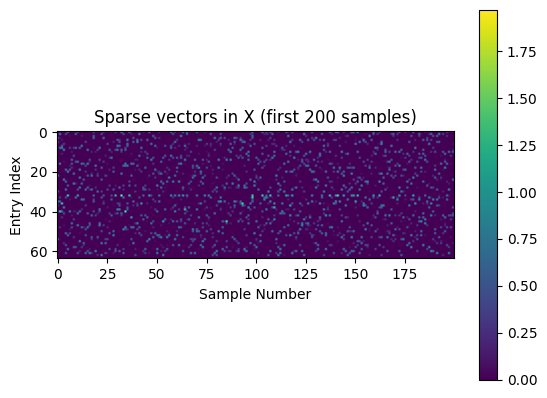

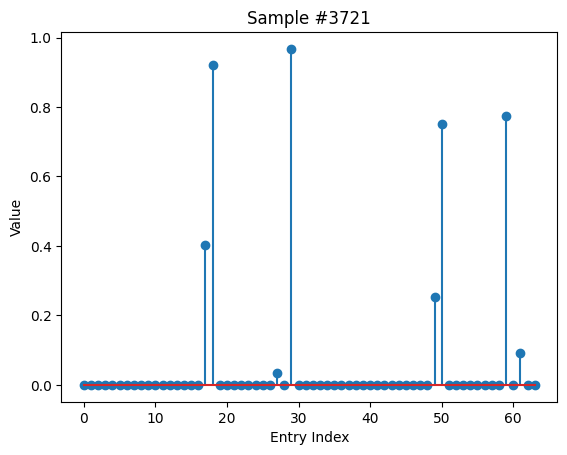

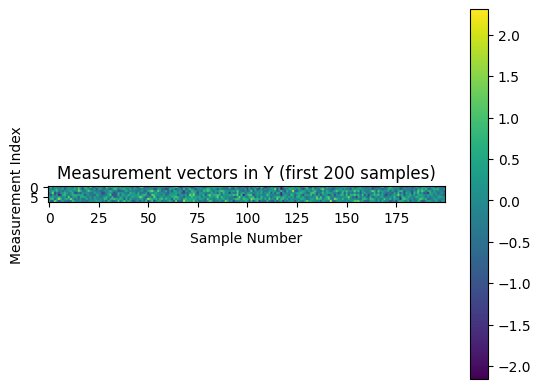

In [5]:
import matplotlib.pyplot as plt

# Plot the first 200 sparse vectors in X
plt.figure()
plt.imshow(X[:,:200])
plt.title('Sparse vectors in X (first 200 samples)')
plt.ylabel('Entry Index')
plt.xlabel('Sample Number')
plt.colorbar()

# Plot a single sample from X
plt.figure()
sample_nr = 3721
plt.stem(X[:,sample_nr])
plt.title(f'Sample #{sample_nr}')
plt.xlabel('Entry Index')
plt.ylabel('Value')

# Plot the first 200 measurement vectors in Y
plt.figure()
plt.imshow(Y[:,:200])
plt.title('Measurement vectors in Y (first 200 samples)')
plt.ylabel('Measurement Index')
plt.xlabel('Sample Number')
plt.colorbar()

# Signal-to-noise ratio
noise_power = noise_var #np.mean(np.square(V))
signal_power = np.mean(np.square(A @ X))
snr_db = 10 * np.log10(signal_power / noise_power)
print(f"SNR = {snr_db:.2f} dB")

## CS Reconstruction without exploiting support structure

Lasso regression to reconstruct *X* from *Y* and *A*:

In [6]:
start_time = time.time()

lasso = Lasso(alpha=0.1).fit(A, Y)
X_rec = lasso.coef_.T

end_time = time.time()
lasso_execution_time = end_time - start_time
print(f"LASSO execution time: {lasso_execution_time:.3f} seconds")

MSE = mean_squared_error(X_rec, X)
print(f'Total MSE = {MSE:.4f}')

LASSO execution time: 0.311 seconds
Total MSE = 0.0470


Results for a given sample:

MSE for sample #5 = 0.1512


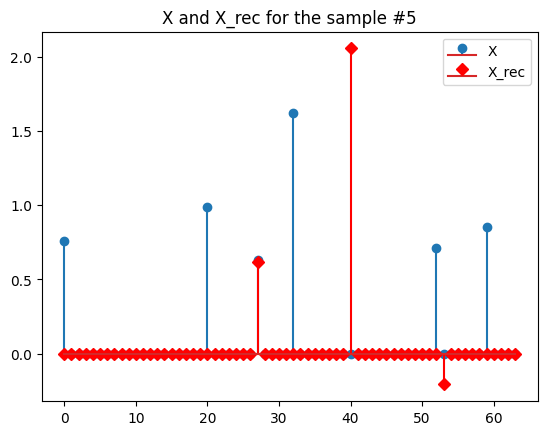

In [7]:
sample_nr = 5
mse_sample = mean_squared_error(X_rec[:,sample_nr], X[:,sample_nr])
print(f"MSE for sample #{sample_nr} = {mse_sample:.4f}")
plt.figure()
plt.title(f"X and X_rec for the sample #{sample_nr}")
plt.stem(X[:,sample_nr])
plt.stem(X_rec[:,sample_nr], linefmt='red', markerfmt='D')
plt.legend(("X","X_rec"))
plt.show()

We see that the reconstructed signal is different than the original signal and also the l_0 norms differ:

In [8]:
print(f"Original signal l0 norm = {np.linalg.norm(X[:,sample_nr], ord=0)}")
print(f"Reconstructed signal l0 norm = {np.linalg.norm(X_rec[:,sample_nr], ord=0)}")

Original signal l0 norm = 6.0
Reconstructed signal l0 norm = 3.0


## CS Reconstruction using knowledge of the support structure - Approach 1

In [9]:
from utils.recover_structured_sparse_signal_with_regularization import *

In [21]:
X.shape, Y.shape, A.shape

((64, 5000), (8, 5000), (8, 64))

In [27]:
# def recover_signal(y):
#     return recover_structured_sparse_signal_with_regularization(CS_mat=A, y=y, alpha=0.1)

# X_rec_structured = np.zeros_like(X)
# with Pool() as pool:
#     items = [Y[:,i] for i in range(Y.shape[1])]
#     for i, result in enumerate(pool.starmap(recover_signal, items)):
#         X_rec_structured[:,i] = result

In [1]:
start_time = time.time()

X_rec_structured = np.apply_along_axis(lambda y: recover_structured_sparse_signal_with_regularization(CS_mat=A, y=y, alpha=0.1), axis=1, arr=Y)

end_time = time.time()
structured_execution_time = end_time - start_time
print(f"Structured signal reconstruction execution time: {structured_execution_time:.3f} seconds")

In [15]:
MSE = mean_squared_error(X_rec_structured, X)
print(f'Total MSE = {MSE:.4f}')

Total MSE = 0.0467


MSE for sample #4343 = 0.0621


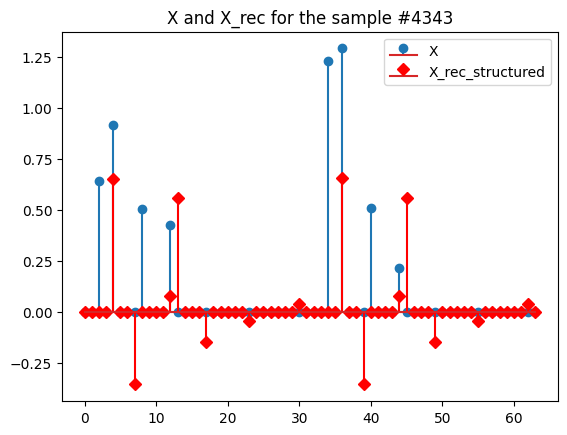

In [18]:
sample_nr = 4343
mse_sample = mean_squared_error(X_rec_structured[:,sample_nr], X[:,sample_nr])
# X_rec_structured_sample = recover_structured_sparse_signal_with_regularization(A, Y[:,sample_nr], K, alpha=0.1)
mse_sample = mean_squared_error(X_rec_structured[:,sample_nr], X[:,sample_nr])
print(f"MSE for sample #{sample_nr} = {mse_sample:.4f}")
plt.figure()
plt.title(f"X and X_rec for the sample #{sample_nr}")
plt.stem(X[:,sample_nr])
plt.stem(X_rec_structured[:,sample_nr], linefmt='red', markerfmt='D')
# plt.stem(X_rec_structured_sample, linefmt='red', markerfmt='D')
plt.legend(("X","X_rec_structured"))
plt.show()